In [55]:
from yucca.modules.data.augmentation.transforms import (
    Torch_BiasField,
    Torch_Blur,
    Torch_CropPad,
    Torch_Gamma,
    Torch_MotionGhosting,
    Torch_Mask,
    Torch_GibbsRinging,
    Torch_SimulateLowres,
    Torch_Spatial,
    Torch_AdditiveNoise,
    Torch_MultiplicativeNoise,
)


from nibabel.testing import data_path
import nibabel as nib
import os
from copy import deepcopy
import numpy as np
import timeit
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

np.random.seed(4215235)
iterations = 2

example_file = os.path.join(data_path, "example4d.nii.gz")
im_real = torch.tensor(nib.load(example_file).get_fdata()[:, :, :, 0], dtype=torch.float)
print(im_real.shape)

dd_real = {"image": im_real.unsqueeze(0)}
im_notreal_gpu = torch.randn((2, 256, 256, 256), dtype=torch.float).to("mps")
seg_notreal_gpu = torch.randint(0, 4, (1, 256, 256, 256), dtype=torch.int).to("mps")
dd_fake_gpu = {"image": im_notreal_gpu, "label": seg_notreal_gpu}

im_notreal_cpu = im_notreal_gpu.clone().to("cpu")
seg_notreal_cpu = seg_notreal_gpu.clone().to("cpu")
dd_fake_cpu = {"image": im_notreal_cpu, "label": seg_notreal_cpu}

torch.Size([128, 96, 24])


In [6]:
def plot(dd):
    plt.imshow(dd["image"][0, :, :, 12], cmap="gray")
    plt.show()


def test_tf(tform, real, fake_on_cpu, fake_on_gpu):
    print(
        "tform gpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_gpu)), number=iterations) / iterations,
        "\n ",
        "tform cpu: ",
        timeit.timeit(lambda: tform(deepcopy(fake_on_cpu)), number=iterations) / iterations,
    )

    tf_real = tf(deepcopy(real))
    plot(tf_real)

tform gpu:  0.003278832999058068 
  tform cpu:  0.10679070849437267


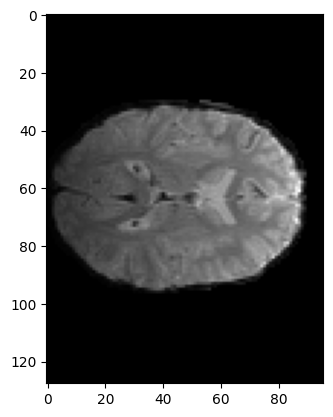

In [7]:
tf = Torch_BiasField(p_per_channel=1)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.11135664547327906 
  tform cpu:  2.897351062449161


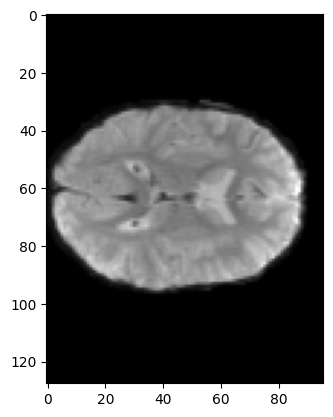

In [34]:
tf = Torch_Blur(p_per_channel=1.0, sigma=(0.5, 0.5))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.0012703539687208831 
  tform cpu:  0.06852472899481654


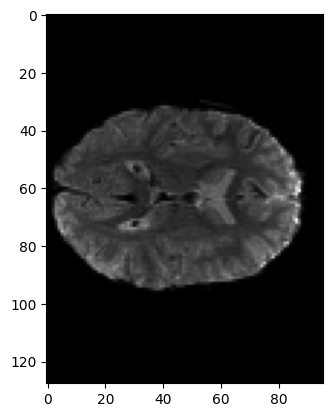

In [40]:
tf = Torch_Gamma(p_all_channel=1, gamma_range=(2, 2), p_invert_image=0)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.06069914600811899 
  tform cpu:  0.6866327289608307


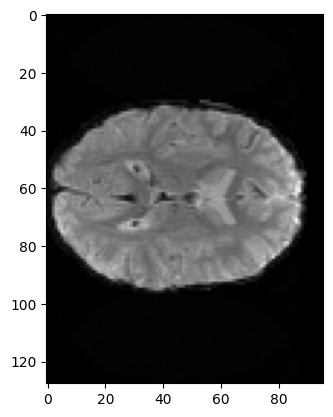

In [ ]:
tf = Torch_MotionGhosting(p_per_channel=1, alpha=(0.95, 0.95), num_reps=(4, 5), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.1586723544751294 
  tform cpu:  0.7715169790317304


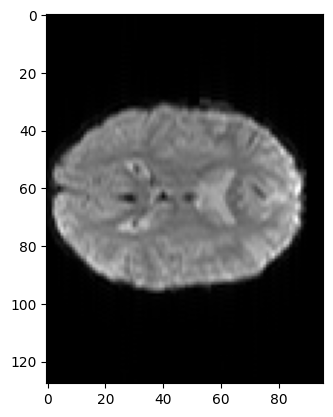

In [50]:
tf = Torch_GibbsRinging(p_per_channel=1, cut_freq=(66, 67), axes=(0, 1))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.09882947948062792 
  tform cpu:  0.028049833490513265


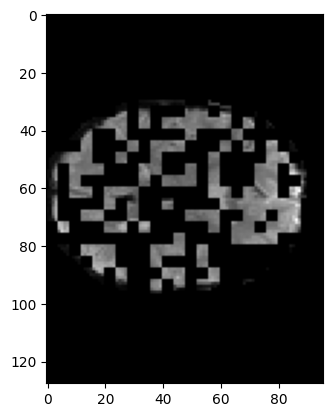

In [12]:
tf = Torch_Mask(ratio=0.5)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.0035604789736680686 
  tform cpu:  0.4061778124887496


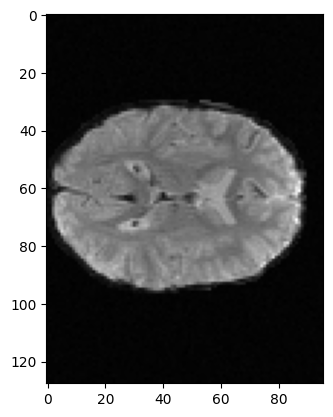

In [ ]:
tf = Torch_AdditiveNoise(p_per_channel=1, mean=(0, 0), sigma=(5, 5))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.003245542000513524 
  tform cpu:  0.39078687503933907


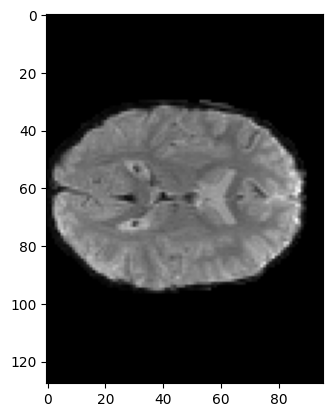

In [71]:
tf = Torch_MultiplicativeNoise(p_per_channel=1, mean=(0, 0), sigma=(0.01, 0.01))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.06986241647973657 
  tform cpu:  0.04550231248140335


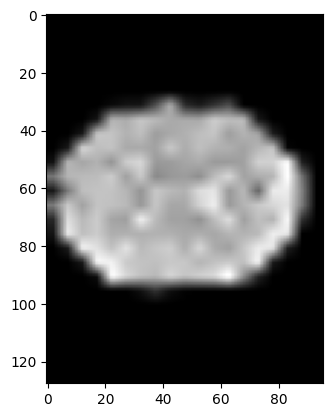

In [53]:
tf = Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.2, 0.2))
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.31096954201348126 
  tform cpu:  0.15394887496950105


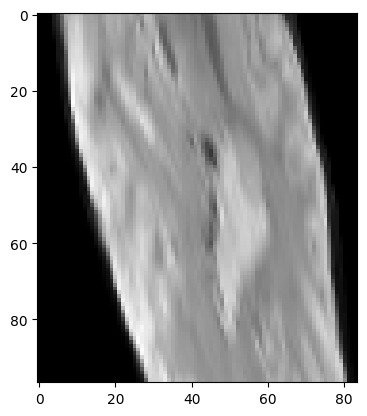

In [14]:
tf = Torch_Spatial(
    patch_size=(97, 84, 24), p_deform_all_channel=1, p_rot_all_channel=1, p_rot_per_axis=1, p_scale_all_channel=1
)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)

tform gpu:  0.12361029197927564 
  tform cpu:  0.14299239602405578


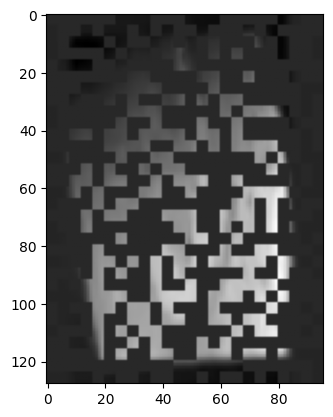

In [ ]:
tf = Compose(
    [
        Torch_CropPad(patch_size=(168, 128, 32)),
        Torch_Spatial(
            patch_size=(128, 96, 24),
            p_deform_all_channel=1,
            p_rot_all_channel=1,
            p_rot_per_axis=1,
            p_scale_all_channel=1,
            deform_alpha=(3, 3),
            deform_sigma=(3, 3),
            random_crop=False,
        ),
        Torch_BiasField(p_per_channel=1.0),
        Torch_Blur(p_per_channel=1.0),
        Torch_Gamma(p_all_channel=1),
        Torch_MotionGhosting(p_per_channel=1, alpha=(0.7, 0.8), num_reps=(2, 3), axes=(0, 1)),
        Torch_GibbsRinging(p_per_channel=1, cut_freq=(64, 68), axes=(0, 1)),
        Torch_SimulateLowres(p_per_channel=1, p_per_axis=1, zoom_range=(0.8, 0.9)),
        Torch_Mask(),
    ]
)
test_tf(tf, real=dd_real, fake_on_cpu=dd_fake_cpu, fake_on_gpu=dd_fake_gpu)